In [ ]:
import os
import pandas as pd

# Define the directory containing processed data files
PROCESSED_DATA = os.path.join("data", "processed-data")

# File paths for the processed data files WITH features
btc_features_file = os.path.join(PROCESSED_DATA, "btc_1min_with_features.csv.gz")
eth_features_file = os.path.join(PROCESSED_DATA, "eth_1min_with_features.csv.gz")

# Load the featured data into the correct variables
btc_df_features = pd.read_csv(btc_features_file, compression="gzip")
eth_df_features = pd.read_csv(eth_features_file, compression="gzip")

In [13]:
BASE_MODEL_DIR = "/Users/halladaykinsey/capstone-project/capstone-models/models"
BASE_LOG_DIR = "/Users/halladaykinsey/capstone-project/capstone-models/logs"

In [4]:
# Basic summary info 
def basic_info(df, name):
    print(f"\n📄 Dataset: {name}")
    print(f"Shape: {df.shape}")
    print("\n🔑 Columns:")
    print(df.columns.tolist())
    print("\n🕳️ Null Values:")
    print(df.isnull().sum())
    print("\n📊 Summary Stats:")
    print(df.describe().T)

basic_info(btc_df_features, "BTC")
basic_info(eth_df_features, "ETH")


📄 Dataset: BTC
Shape: (6283463, 44)

🔑 Columns:
['Open', 'High', 'Low', 'Close', 'Volume', 'Close_1m_ago', 'PctChange_1m', 'Close_5m_ago', 'PctChange_5m', 'Close_1h_ago', 'PctChange_1h', 'Close_1d_ago', 'PctChange_1d', 'Close_1w_ago', 'PctChange_1w', 'Close_1mo_ago', 'PctChange_1mo', 'SMA_20', 'EMA_20', 'SMA_50', 'EMA_50', 'SMA_200', 'EMA_200', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'VolMA_short', 'VolMA_long', 'VolumeOscillator', 'OBV', 'candle_range', 'body_size', 'Doji', 'ATR', '+DI', '-DI', 'ADX', '%K', '%D', 'Williams_%R']

🕳️ Null Values:
Open                0
High                0
Low                 0
Close               0
Volume              0
Close_1m_ago        0
PctChange_1m        0
Close_5m_ago        0
PctChange_5m        0
Close_1h_ago        0
PctChange_1h        0
Close_1d_ago        0
PctChange_1d        0
Close_1w_ago        0
PctChange_1w        0
Close_1mo_ago       0
PctChange_1mo       0
SMA_20              0
EMA_20  

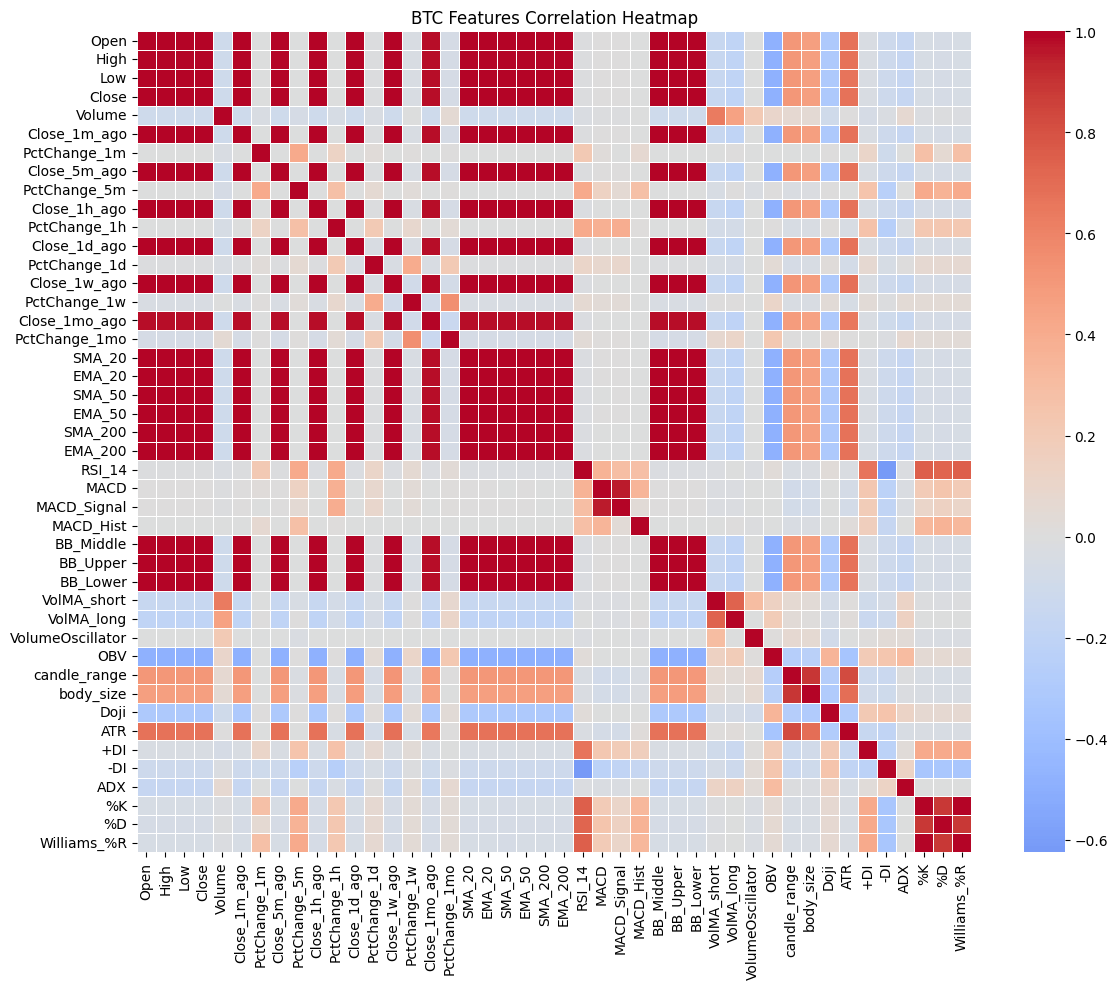

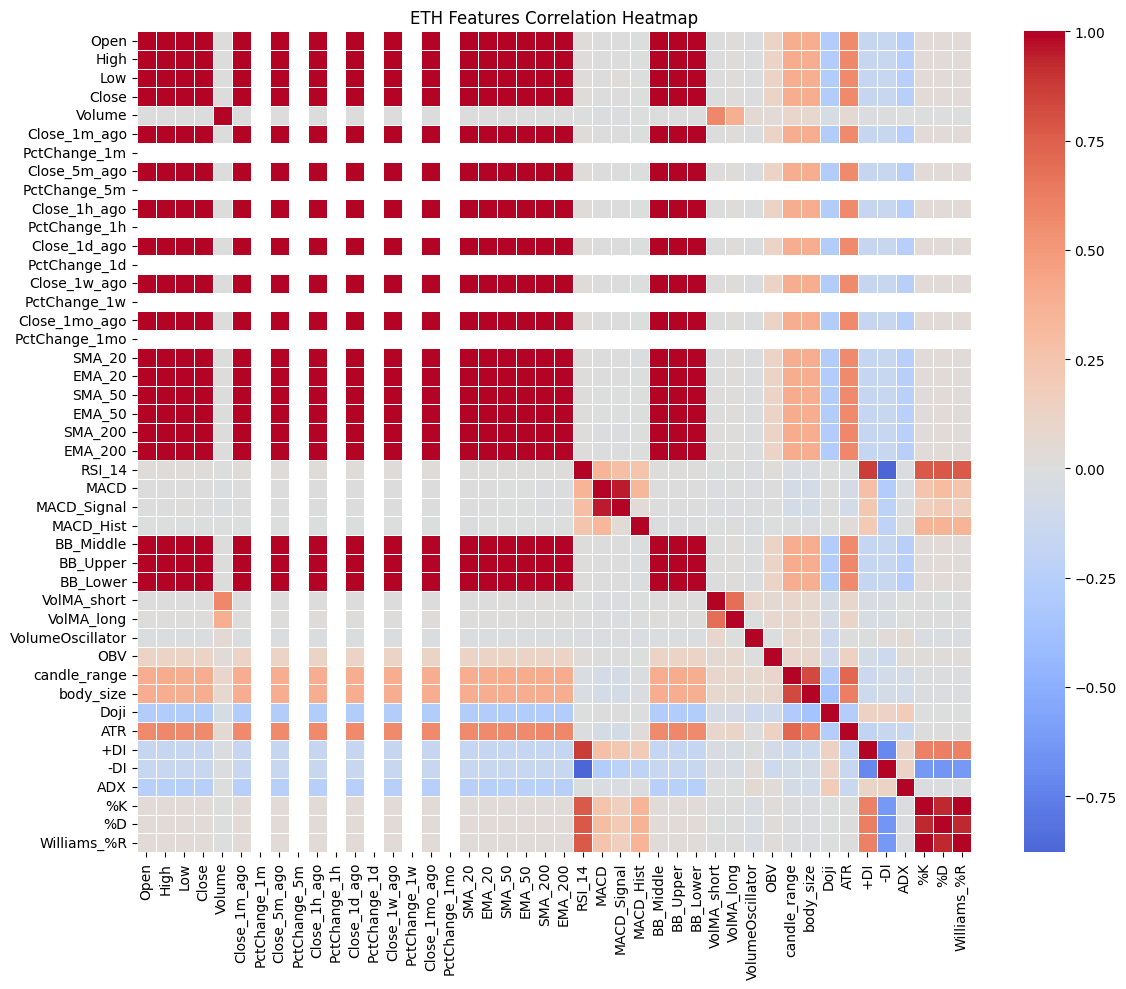

In [6]:
# Correlation Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

def plot_corr_heatmap(df, title):
    numeric_df = df.select_dtypes(include=["number"])
    
    corr = numeric_df.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, fmt=".2f", linewidths=0.5)
    plt.title(f"{title} Correlation Heatmap")
    plt.tight_layout()
    plt.show()

plot_corr_heatmap(btc_df_features, "BTC Features")
plot_corr_heatmap(eth_df_features, "ETH Features")


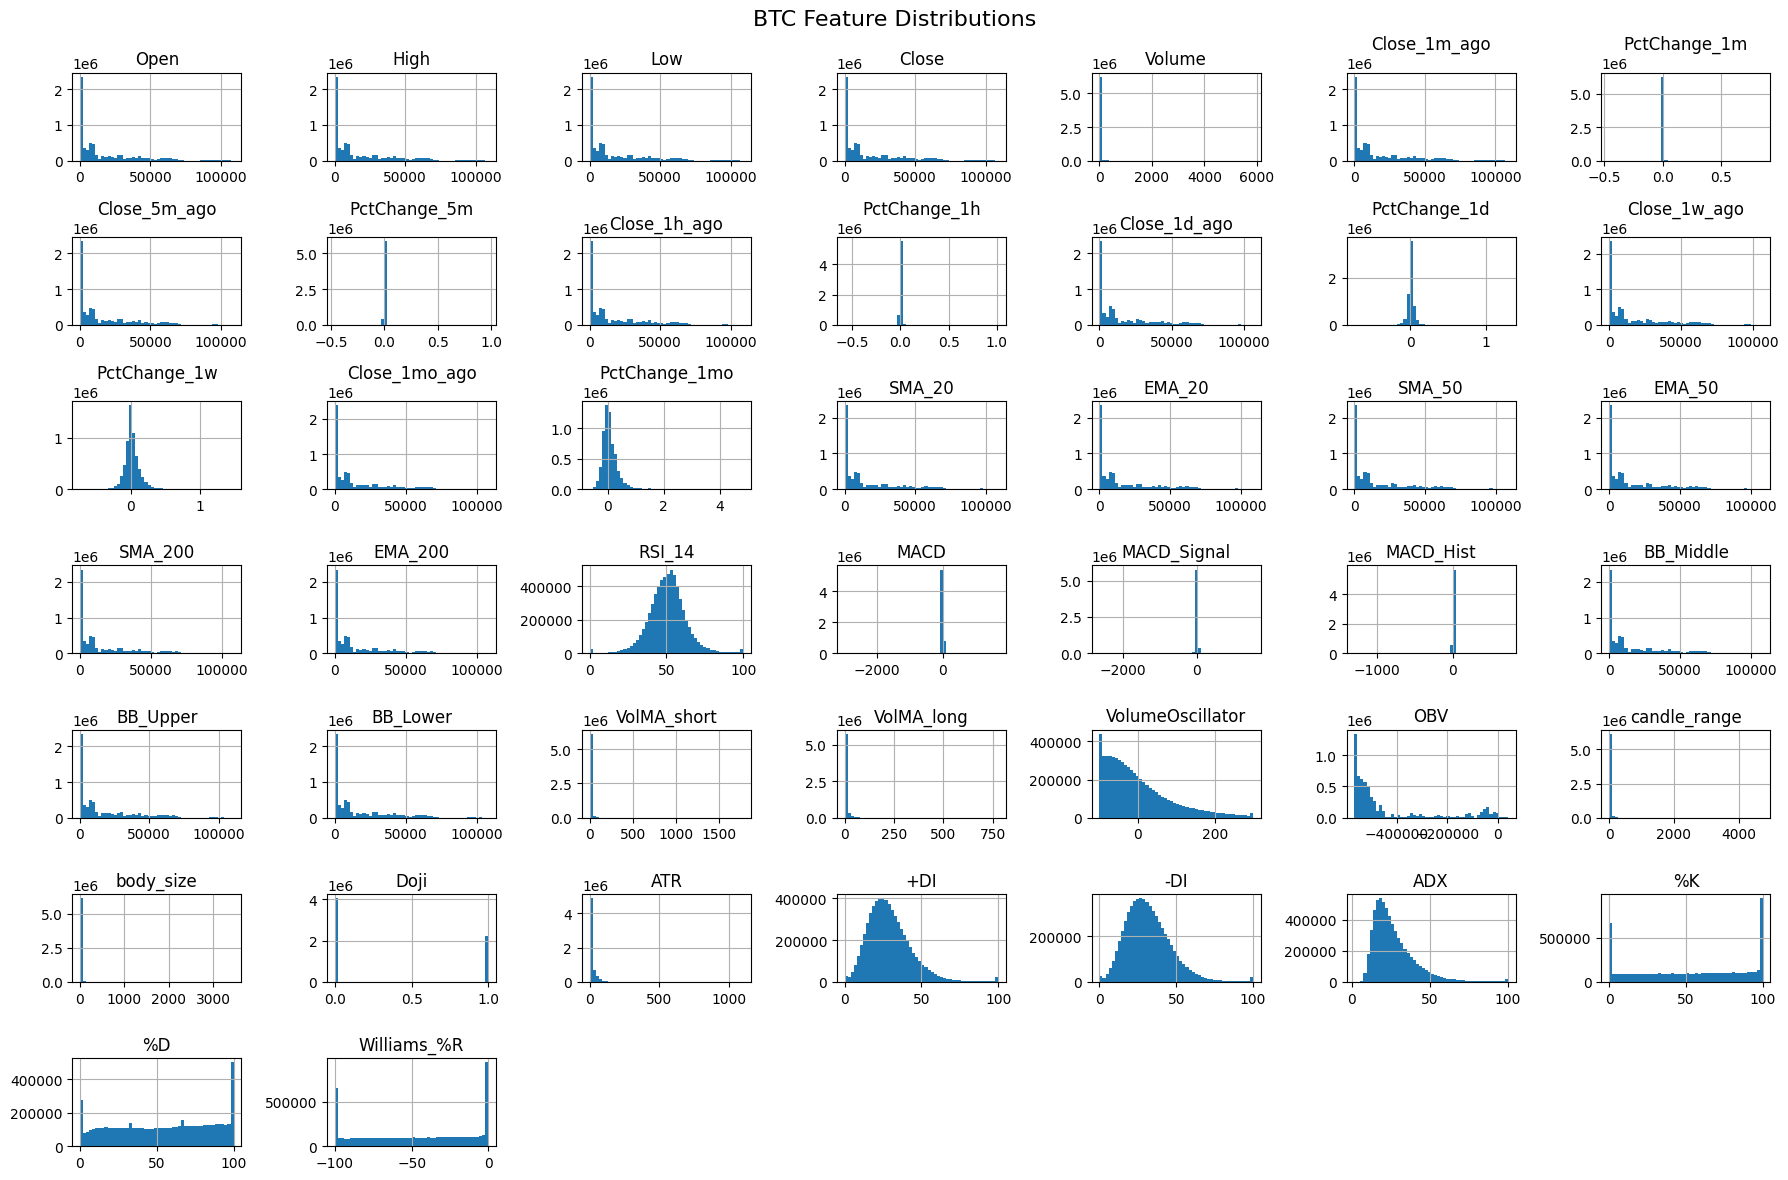

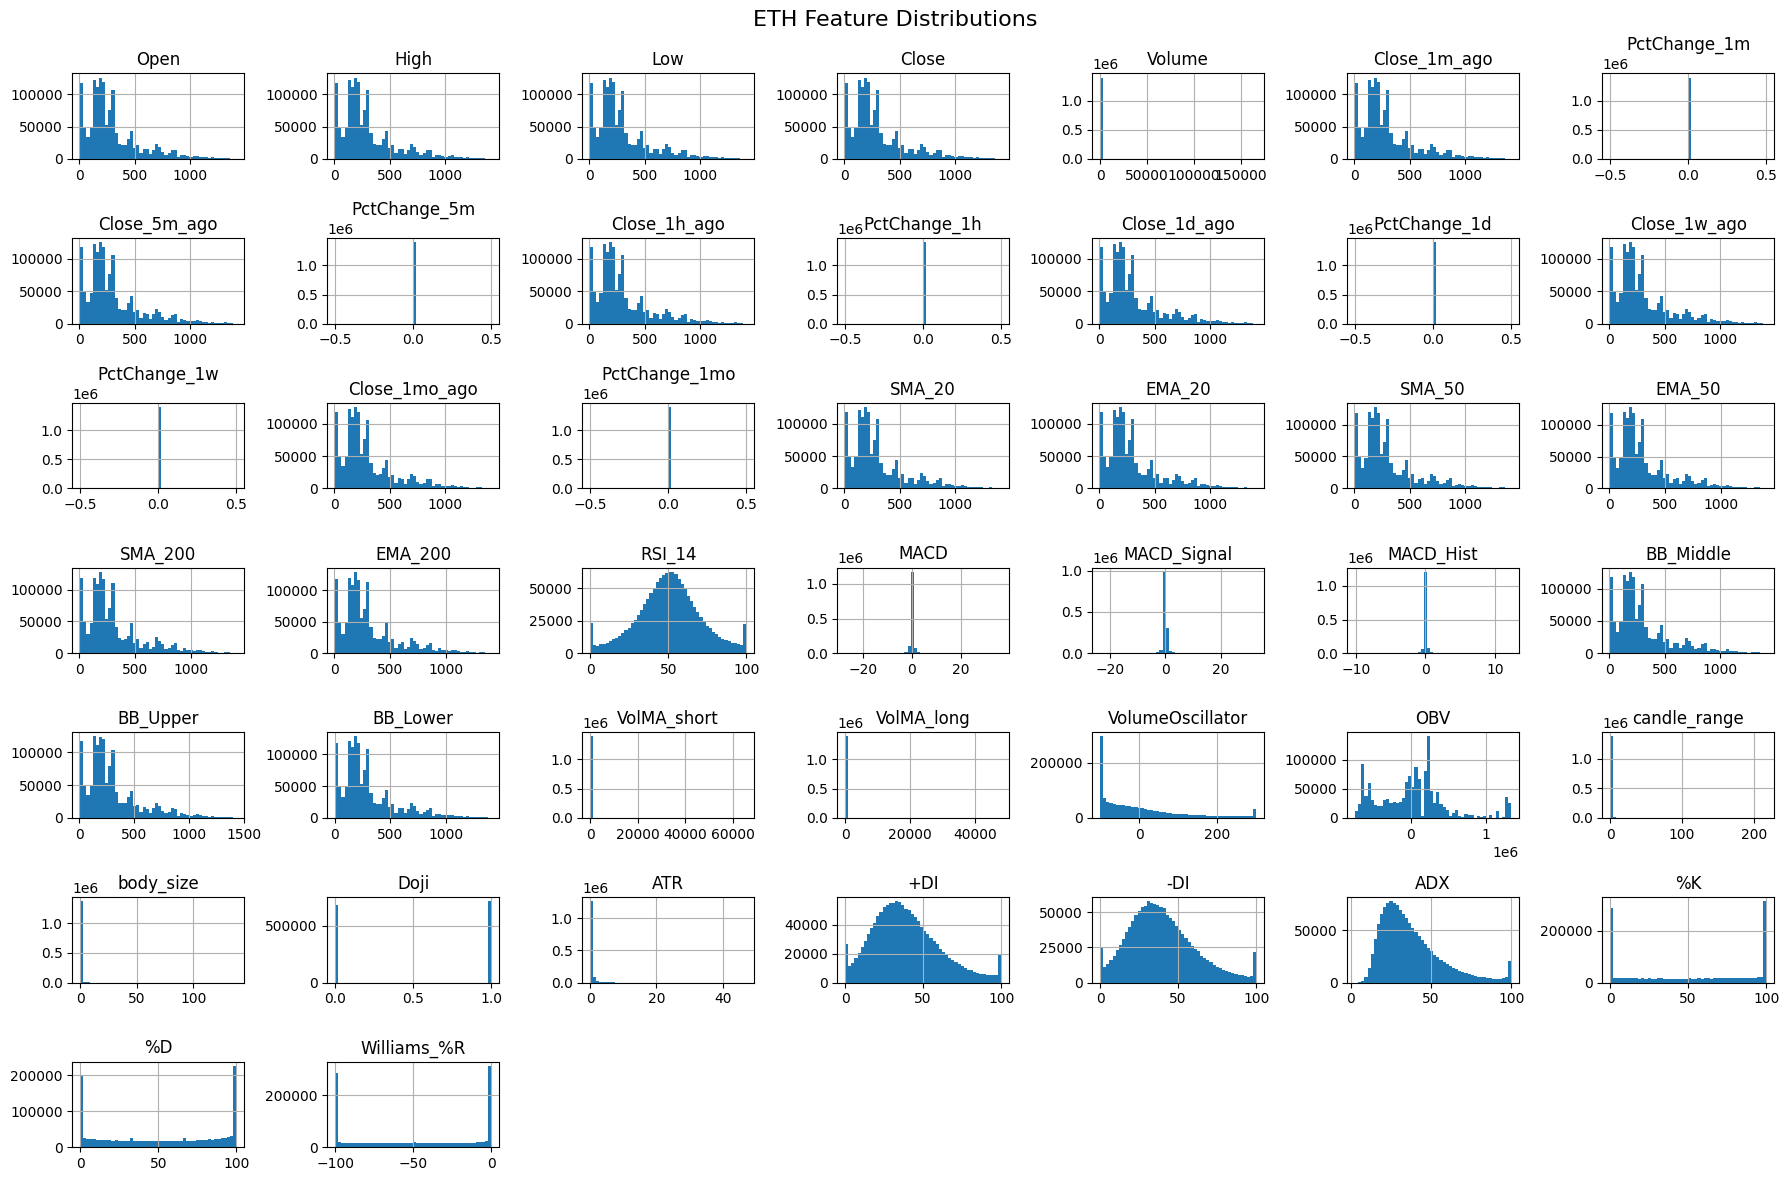

In [7]:
# Feature distribution
def plot_feature_distributions(df, title, bins=50):
    feature_cols = [col for col in df.columns if col.lower() not in ['timestamp', 'datetime', 'symbol', 'target']]
    df[feature_cols].hist(figsize=(18, 12), bins=bins)
    plt.suptitle(f"{title} Feature Distributions", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_feature_distributions(btc_df_features, "BTC")
plot_feature_distributions(eth_df_features, "ETH")

## Modeling

### Preparing Features

In [8]:
import pandas as pd

target_col = "PctChange_1d"
leaky_cols = ["High", "Low", "Close", target_col]  # current-day info

all_cols = btc_df_features.columns.tolist()
input_features = [col for col in all_cols if col not in leaky_cols]

# Creating X and y
X = btc_df_features[input_features]
y = btc_df_features[target_col]

# Sampling
X_sample = X.sample(frac=0.03, random_state=42)
y_sample = y.loc[X_sample.index]

print(f"Sampled shape: {X_sample.shape}")
print(f"Target mean (sanity check): {y_sample.mean():.6f}")

Sampled shape: (188504, 40)
Target mean (sanity check): 0.002686


In [9]:
from sklearn.preprocessing import StandardScaler

# pull out the 'Open' column
open_anchor = X_sample["Open"].copy()

X_to_scale = X_sample.drop(columns=["Open"])

scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_to_scale)

# Reconstructing df & adding 'Open' as is
X_scaled = pd.DataFrame(X_scaled_array, columns=X_to_scale.columns, index=X_to_scale.index)
X_scaled["Open"] = open_anchor  # <- Unscaled "anchor"

# Open to first
cols = ["Open"] + [col for col in X_scaled.columns if col != "Open"]
X_scaled = X_scaled[cols]

X_scaled.head()

,Open,Volume,Close_1m_ago,PctChange_1m,Close_5m_ago,PctChange_5m,Close_1h_ago,PctChange_1h,Close_1d_ago,Close_1w_ago,...,candle_range,body_size,Doji,ATR,+DI,-DI,ADX,%K,%D,Williams_%R
5614423,29278.00,-0.116595,0.619052,0.037569,0.619392,-0.044878,0.627966,-0.645617,0.626073,0.616878,...,-0.380325,-0.308159,-0.743808,-0.195597,-0.041139,1.082954,-0.356334,-1.409053,-1.605055,-1.409053
2582735,7020.01,-0.167176,-0.437579,1.007137,-0.438987,1.433999,-0.439992,0.903909,-0.420209,-0.476267,...,-0.220797,-0.075956,-0.743808,-0.030223,-0.300981,-0.714288,-0.673562,0.740143,-0.015620,0.740143
5527364,25039.00,-0.233000,0.417962,-0.274546,0.417873,-0.099522,0.419241,-0.169373,0.463415,0.490512,...,0.000260,0.061886,-0.743808,-0.239856,0.156082,0.169443,-0.773855,0.277006,1.013846,0.277006
484062,197.00,-0.206947,-0.761147,-0.001371,-0.761150,-0.052590,-0.761145,0.369031,-0.761256,-0.760300,...,-0.443756,-0.400671,1.344433,-0.582792,-0.270393,0.392746,-0.662297,-1.549558,-1.725548,-1.549558
3320331,4964.71,-0.005251,-0.534723,0.035349,-0.534915,0.203442,-0.535507,0.339510,-0.543244,-0.578879,...,-0.334021,-0.243402,-0.743808,-0.510235,1.193667,-1.111922,1.434948,1.330794,1.277855,1.330794


In [10]:
# Creating sequences for sequence models

import numpy as np

sequence_length = 30

def create_sequences(X, y, sequence_length):
    X_seq = []
    y_seq = []

    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])
        y_seq.append(y[i])

    return np.array(X_seq), np.array(y_seq)

# Apply the function
X_seq, y_seq = create_sequences(X_scaled.values, y.values, sequence_length)

# Sanity check
print(f"Sequence input shape: {X_seq.shape}")
print(f"Target shape: {y_seq.shape}")

Sequence input shape: (188474, 30, 40)
Target shape: (188474,)


In [11]:
# 80% train, 10% val, 10% test
train_size = int(len(X_seq) * 0.8)
val_size = int(len(X_seq) * 0.1)

X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")

Train: (150779, 30, 40), (150779,)
Val:   (18847, 30, 40), (18847,)
Test:  (18848, 30, 40), (18848,)


### LSTM

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LayerNormalization(input_shape=(30, 40)),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['mae']
)
model.summary()

/Users/halladaykinsey/myenv/lib/python3.12/site-packages/keras/src/layers/normalization/layer_normalization.py:125: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer_normalization             │ (None, 30, 40)         │            80 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 128)        │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,129 (539.57 KB)

 Trainable params: 138,129 (539.57 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

# Set this once for the model you're training
model_name = "lstm_v4"

# Construct dynamic paths
checkpoint_path = f"{BASE_MODEL_DIR}/{model_name}_model.h5"
csv_log_path = f"{BASE_LOG_DIR}/{model_name}_log.csv"

checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

csv_logger_cb = CSVLogger(csv_log_path, append=True)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[checkpoint_cb, csv_logger_cb, earlystop_cb],
    verbose=1
)


Epoch 1/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0016 - mae: 0.0252
Epoch 1: val_loss improved from inf to 0.00468, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/lstm_v4_model.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 99s 42ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0047 - val_mae: 0.0484
Epoch 2/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0016 - mae: 0.0252
Epoch 2: val_loss improved from 0.00468 to 0.00467, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/lstm_v4_model.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 98s 41ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0047 - val_mae: 0.0483
Epoch 3/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0016 - mae: 0.0253
Epoch 3: val_loss did not improve from 0.00467
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 96s 41ms/step - loss: 0.0016 - mae: 0.0253 - val_loss: 0.0047 - val_mae: 0.0488
Epoch 4/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0016 - mae: 0.0251
Epoch 4: val_loss did not improve from 0.00467
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - loss: 0.0016 - mae: 0.0251 - val_loss: 0.0047 - val_mae: 0.0484
Epoch 5/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0016 - mae: 0.0251
Epoch 5: val_loss did not improve from 0.00467
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 98s 42ms/step - loss: 0.0016 - mae: 0.0251 - val_loss: 0.0047 - val_mae: 0.0487
Epoch 6/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0016 - mae: 0.0252
Epoch 6: val_loss improved from 0.00467 to 0.00461, saving model to /Users/hal

2356/2356 ━━━━━━━━━━━━━━━━━━━━ 99s 42ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0046 - val_mae: 0.0479
Epoch 7/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0016 - mae: 0.0254
Epoch 7: val_loss did not improve from 0.00461
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - loss: 0.0016 - mae: 0.0254 - val_loss: 0.0047 - val_mae: 0.0482
Epoch 8/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0016 - mae: 0.0253
Epoch 8: val_loss did not improve from 0.00461
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - loss: 0.0016 - mae: 0.0253 - val_loss: 0.0047 - val_mae: 0.0483
Epoch 9/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0016 - mae: 0.0251
Epoch 9: val_loss did not improve from 0.00461
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - loss: 0.0016 - mae: 0.0251 - val_loss: 0.0046 - val_mae: 0.0481
Epoch 10/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0016 - mae: 0.0253
Epoch 10: val_loss did not improve from 0.00461
2356/2356 ━━━━━━━━━━━━━━━━━

In [16]:
# Standard regression metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model.load_weights(checkpoint_path)

y_pred = model.predict(X_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²:   {r2:.4f}")

589/589 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
MAE:  0.071457
RMSE: 0.088165
R²:   -0.3582


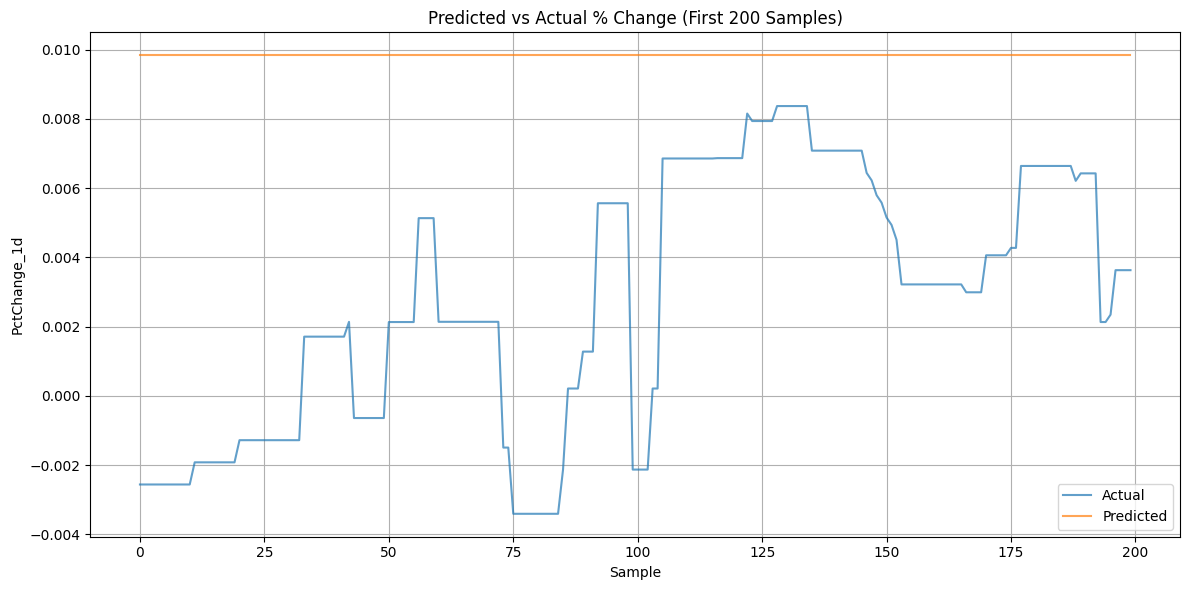

In [17]:
# Actual vs predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test[:200], label="Actual", alpha=0.7)
plt.plot(y_pred[:200], label="Predicted", alpha=0.7)
plt.title("Predicted vs Actual % Change (First 200 Samples)")
plt.xlabel("Sample")
plt.ylabel("PctChange_1d")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Define direction (positive = 1, negative = 0)
actual_dir = (y_test > 0).astype(int)
pred_dir = (y_pred > 0).astype(int)

directional_accuracy = (actual_dir == pred_dir).mean()
print(f"Directional Accuracy: {directional_accuracy:.2%}")

Directional Accuracy: 81.50%


### GRU

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)  # Predicting a single % change value
])

gru_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

gru_model.summary()

/Users/halladaykinsey/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 30, 64)         │        20,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,793 (116.38 KB)

 Trainable params: 29,793 (116.38 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
gru_checkpoint = os.path.join(BASE_MODEL_DIR, 'gru_best_model.h5')
gru_csv_log = os.path.join(BASE_LOG_DIR, 'gru_training_log.csv')

checkpoint_cb = ModelCheckpoint(gru_checkpoint, monitor='val_loss', save_best_only=True, verbose=1)
csv_logger_cb = CSVLogger(gru_csv_log, append=True)

history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[checkpoint_cb, csv_logger_cb, earlystop_cb],
    verbose=1
)

Epoch 1/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0151 - mae: 0.0695
Epoch 1: val_loss improved from inf to 0.00466, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/gru_best_model.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - loss: 0.0151 - mae: 0.0695 - val_loss: 0.0047 - val_mae: 0.0482
Epoch 2/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017 - mae: 0.0258
Epoch 2: val_loss did not improve from 0.00466
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0017 - mae: 0.0258 - val_loss: 0.0049 - val_mae: 0.0500
Epoch 3/30
2353/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016 - mae: 0.0254
Epoch 3: val_loss improved from 0.00466 to 0.00456, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/gru_best_model.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0016 - mae: 0.0254 - val_loss: 0.0046 - val_mae: 0.0477
Epoch 4/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016 - mae: 0.0254
Epoch 4: val_loss did not improve from 0.00456
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0016 - mae: 0.0254 - val_loss: 0.0046 - val_mae: 0.0481
Epoch 5/30
2354/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016 - mae: 0.0252
Epoch 5: val_loss did not improve from 0.00456
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0047 - val_mae: 0.0486
Epoch 6/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016 - mae: 0.0251
Epoch 6: val_loss did not improve from 0.00456
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0016 - mae: 0.0251 - val_loss: 0.0047 - val_mae: 0.0489
Epoch 7/30
2354/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015 - mae: 0.0250
Epoch 7: val_loss did not improve from 0.00456
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 4

589/589 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
📈 GRU Evaluation Metrics
MSE: 0.007773
MAE: 0.071457
R²:  -0.358152


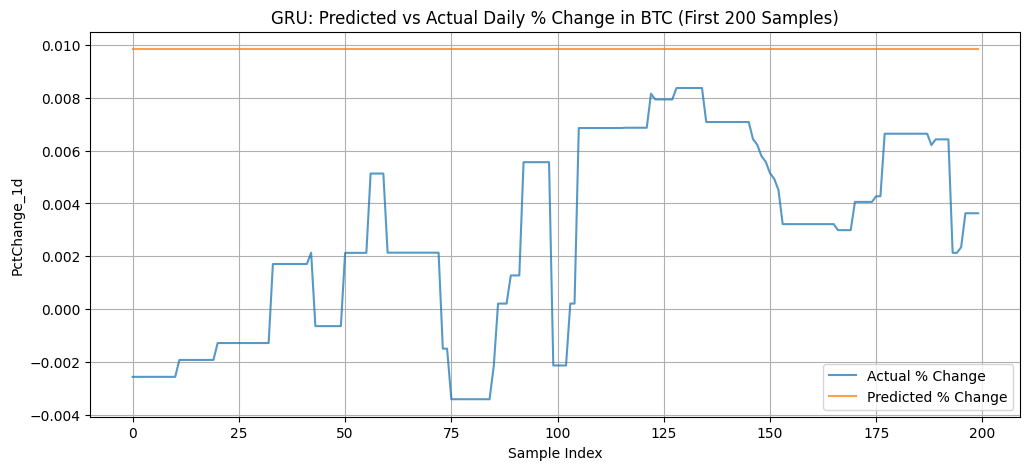

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on test set
y_pred_gru = model.predict(X_test).flatten()

# Evaluation metrics
mse_gru = mean_squared_error(y_test, y_pred_gru)
mae_gru = mean_absolute_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)

print("📈 GRU Evaluation Metrics")
print(f"MSE: {mse_gru:.6f}")
print(f"MAE: {mae_gru:.6f}")
print(f"R²:  {r2_gru:.6f}")

# Visualization
plt.figure(figsize=(12, 5))
plt.plot(y_test[:200], label='Actual % Change', alpha=0.75)
plt.plot(y_pred_gru[:200], label='Predicted % Change', alpha=0.75)
plt.title("GRU: Predicted vs Actual Daily % Change in BTC (First 200 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("PctChange_1d")
plt.legend()
plt.grid(True)
plt.show()

### RNN

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Define the RNN model
rnn_model = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    SimpleRNN(32),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
rnn_model.summary()

/Users/halladaykinsey/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 64)         │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
checkpoint_path = os.path.join(BASE_MODEL_DIR, "rnn_v4.h5")
csv_log_path = os.path.join(BASE_LOG_DIR, "rnn_v4_log.csv")

# Callbacks
checkpoint_cb = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1
)

csv_logger_cb = CSVLogger(csv_log_path, append=True)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_rnn = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[checkpoint_cb, csv_logger_cb, earlystop_cb],
    verbose=1
)

Epoch 1/30
2352/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0175 - mae: 0.0918
Epoch 1: val_loss improved from inf to 0.00467, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/rnn_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0174 - mae: 0.0917 - val_loss: 0.0047 - val_mae: 0.0483
Epoch 2/30
2349/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0257
Epoch 2: val_loss did not improve from 0.00467
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0016 - mae: 0.0257 - val_loss: 0.0048 - val_mae: 0.0493
Epoch 3/30
2352/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mae: 0.0260
Epoch 3: val_loss did not improve from 0.00467
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0017 - mae: 0.0260 - val_loss: 0.0049 - val_mae: 0.0501
Epoch 4/30
2349/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0259
Epoch 4: val_loss did not improve from 0.00467
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0016 - mae: 0.0259 - val_loss: 0.0047 - val_mae: 0.0486
Epoch 5/30
2350/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mae: 0.0259
Epoch 5: val_loss improved from 0.00467 to 0.00459, saving model to /Users/halladaykins

2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0017 - mae: 0.0259 - val_loss: 0.0046 - val_mae: 0.0478
Epoch 6/30
2353/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mae: 0.0261
Epoch 6: val_loss did not improve from 0.00459
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0017 - mae: 0.0261 - val_loss: 0.0048 - val_mae: 0.0488
Epoch 7/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0259
Epoch 7: val_loss improved from 0.00459 to 0.00455, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/rnn_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0016 - mae: 0.0259 - val_loss: 0.0045 - val_mae: 0.0476
Epoch 8/30
2353/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0258
Epoch 8: val_loss did not improve from 0.00455
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0016 - mae: 0.0258 - val_loss: 0.0046 - val_mae: 0.0480
Epoch 9/30
2353/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mae: 0.0258
Epoch 9: val_loss did not improve from 0.00455
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0017 - mae: 0.0258 - val_loss: 0.0047 - val_mae: 0.0485
Epoch 10/30
2350/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mae: 0.0258
Epoch 10: val_loss improved from 0.00455 to 0.00454, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/rnn_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0017 - mae: 0.0258 - val_loss: 0.0045 - val_mae: 0.0475
Epoch 11/30
2350/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0257
Epoch 11: val_loss did not improve from 0.00454
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0016 - mae: 0.0257 - val_loss: 0.0048 - val_mae: 0.0491
Epoch 12/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0257
Epoch 12: val_loss did not improve from 0.00454
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0016 - mae: 0.0257 - val_loss: 0.0046 - val_mae: 0.0481
Epoch 13/30
2352/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0255
Epoch 13: val_loss did not improve from 0.00454
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0016 - mae: 0.0255 - val_loss: 0.0047 - val_mae: 0.0487
Epoch 14/30
2354/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0255
Epoch 14: val_loss did not improve from 0.00454
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 1

2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0016 - mae: 0.0255 - val_loss: 0.0045 - val_mae: 0.0475
Epoch 18/30
2352/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0254
Epoch 18: val_loss did not improve from 0.00453
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0016 - mae: 0.0254 - val_loss: 0.0046 - val_mae: 0.0482
Epoch 19/30
2354/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0255
Epoch 19: val_loss improved from 0.00453 to 0.00439, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/rnn_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0016 - mae: 0.0255 - val_loss: 0.0044 - val_mae: 0.0468
Epoch 20/30
2351/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0255
Epoch 20: val_loss did not improve from 0.00439
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0016 - mae: 0.0255 - val_loss: 0.0047 - val_mae: 0.0488
Epoch 21/30
2352/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0254
Epoch 21: val_loss did not improve from 0.00439
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0016 - mae: 0.0254 - val_loss: 0.0047 - val_mae: 0.0485
Epoch 22/30
2350/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0254
Epoch 22: val_loss did not improve from 0.00439
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0016 - mae: 0.0254 - val_loss: 0.0047 - val_mae: 0.0487
Epoch 23/30
2349/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mae: 0.0256
Epoch 23: val_loss did not improve from 0.00439
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 1

In [27]:
# eval
rnn_preds = rnn_model.predict(X_test).flatten()

rmse = np.sqrt(mean_squared_error(y_test, rnn_preds))
mae = mean_absolute_error(y_test, rnn_preds)
r2 = r2_score(y_test, rnn_preds)

print(f"RNN Test RMSE: {rmse:.6f}")
print(f"RNN Test MAE:  {mae:.6f}")
print(f"RNN Test R²:   {r2:.6f}")

589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RNN Test RMSE: 0.084597
RNN Test MAE:  0.068437
RNN Test R²:   -0.250453


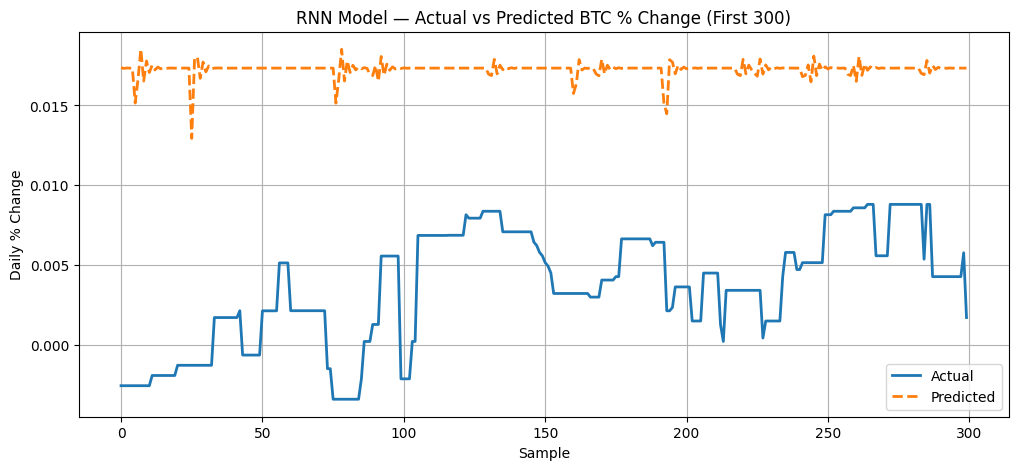

In [28]:
plt.figure(figsize=(12, 5))
plt.plot(y_test[:300], label="Actual", linewidth=2)
plt.plot(rnn_preds[:300], label="Predicted", linewidth=2, linestyle="--")
plt.title("RNN Model — Actual vs Predicted BTC % Change (First 300)")
plt.xlabel("Sample")
plt.ylabel("Daily % Change")
plt.legend()
plt.grid()
plt.show()

### CNN

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense

# Input shape: (30 timesteps, 40 features)
input_shape = (30, 40)
inputs = Input(shape=input_shape)

# First causal conv block
x = Conv1D(64, kernel_size=3, padding="causal", dilation_rate=1)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Save for residual connection
res = x

# Second causal dilated conv block
x = Conv1D(64, kernel_size=3, padding="causal", dilation_rate=2)(x)
x = BatchNormalization()(x)

# Residual connection
x = Add()([x, res])
x = Activation('relu')(x)

# Final pooling & dense layers
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1)(x)  # Predict raw % change

# Define the model
cnn_model = Model(inputs, outputs)
cnn_model.summary()

cnn_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 30, 40)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 64)    │      7,744 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 30, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 64)    │     12,352 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 30, 64)    │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ activation_1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,833 (97.00 KB)

 Trainable params: 24,577 (96.00 KB)

 Non-trainable params: 256 (1.00 KB)

In [32]:
checkpoint_path = os.path.join(BASE_MODEL_DIR, "cnn_v4.h5")
csv_log_path = os.path.join(BASE_LOG_DIR, "cnn_v4_log.csv")

# Callbacks
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

csv_logger_cb = CSVLogger(csv_log_path, append=True)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[checkpoint_cb, csv_logger_cb, earlystop_cb],
    verbose=1
)

Epoch 1/30
2350/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - mae: 0.0294
Epoch 1: val_loss improved from inf to 0.00516, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/cnn_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0018 - mae: 0.0294 - val_loss: 0.0052 - val_mae: 0.0519
Epoch 2/30
2347/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - mae: 0.0279
Epoch 2: val_loss improved from 0.00516 to 0.00481, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/cnn_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0017 - mae: 0.0279 - val_loss: 0.0048 - val_mae: 0.0495
Epoch 3/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - mae: 0.0271
Epoch 3: val_loss did not improve from 0.00481
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0017 - mae: 0.0271 - val_loss: 0.0055 - val_mae: 0.0540
Epoch 4/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - mae: 0.0264
Epoch 4: val_loss did not improve from 0.00481
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0016 - mae: 0.0264 - val_loss: 0.0051 - val_mae: 0.0510
Epoch 5/30
2347/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mae: 0.0259
Epoch 5: val_loss improved from 0.00481 to 0.00481, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/cnn_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0016 - mae: 0.0259 - val_loss: 0.0048 - val_mae: 0.0491
Epoch 6/30
2351/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mae: 0.0256
Epoch 6: val_loss did not improve from 0.00481
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0016 - mae: 0.0256 - val_loss: 0.0053 - val_mae: 0.0530
Epoch 7/30
2345/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mae: 0.0255
Epoch 7: val_loss did not improve from 0.00481
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0016 - mae: 0.0255 - val_loss: 0.0050 - val_mae: 0.0500
Epoch 8/30
2348/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mae: 0.0256
Epoch 8: val_loss did not improve from 0.00481
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0016 - mae: 0.0256 - val_loss: 0.0052 - val_mae: 0.0519
Epoch 9/30
2349/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mae: 0.0256
Epoch 9: val_loss improved from 0.00481 to 0.00447, saving model to /Users/halladaykins

2356/2356 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0016 - mae: 0.0256 - val_loss: 0.0045 - val_mae: 0.0477
Epoch 10/30
2352/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - mae: 0.0256
Epoch 10: val_loss did not improve from 0.00447
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0015 - mae: 0.0256 - val_loss: 0.0053 - val_mae: 0.0530
Epoch 11/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - mae: 0.0253
Epoch 11: val_loss did not improve from 0.00447
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0015 - mae: 0.0253 - val_loss: 0.0045 - val_mae: 0.0472
Epoch 12/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - mae: 0.0253
Epoch 12: val_loss did not improve from 0.00447
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0014 - mae: 0.0253 - val_loss: 0.0050 - val_mae: 0.0501
Epoch 13/30
2354/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - mae: 0.0251
Epoch 13: val_loss did not improve from 0.00447
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 1

589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step
MSE: 0.007108
MAE: 0.068517
R^2: -0.2419


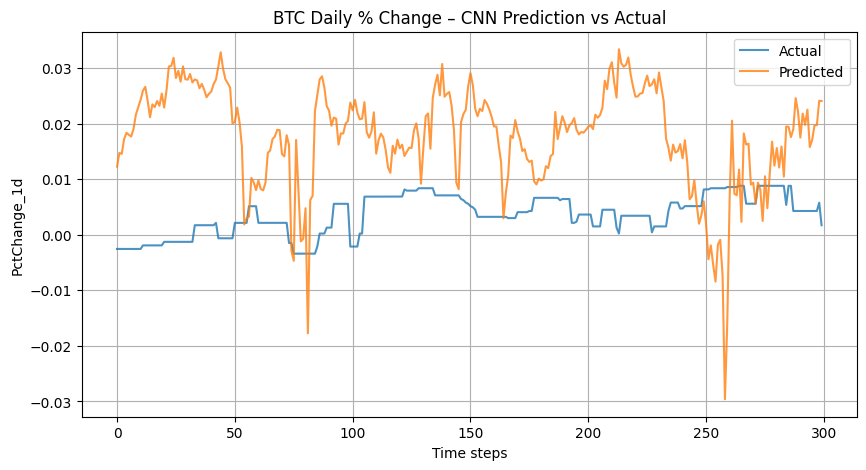

In [33]:
# eval
y_pred = cnn_model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R^2: {r2:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(y_test[:300], label='Actual', alpha=0.8)
plt.plot(y_pred[:300], label='Predicted', alpha=0.8)
plt.title("BTC Daily % Change – CNN Prediction vs Actual")
plt.xlabel("Time steps")
plt.ylabel("PctChange_1d")
plt.legend()
plt.grid()
plt.show()

### Timesnet

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models

# TimesBlock Layer
class TimesBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate=1):
        super(TimesBlock, self).__init__()
        self.conv = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            padding="causal",
            dilation_rate=dilation_rate,
            activation="relu"
        )
        self.norm = layers.BatchNormalization()
        self.residual = layers.Conv1D(filters=filters, kernel_size=1, padding="same")

    def call(self, inputs, training=False):
        x = self.conv(inputs)
        x = self.norm(x, training=training)
        return tf.nn.relu(x + self.residual(inputs))  # Residual connection

def build_timesnet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = inputs
    for dilation_rate in [1, 2, 4, 8]:
        x = TimesBlock(filters=64, kernel_size=3, dilation_rate=dilation_rate)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='linear')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

timesnet_model = build_timesnet_model((30, 40))
timesnet_model.summary()

timesnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 30, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ times_block (TimesBlock)        │ (None, 30, 64)         │        10,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ times_block_1 (TimesBlock)      │ (None, 30, 64)         │        16,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ times_block_2 (TimesBlock)      │ (None, 30, 64)         │        16,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ times_block_3 (TimesBlock)      │ (None, 30, 64)         │        16,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,153 (254.50 KB)

 Trainable params: 64,641 (252.50 KB)

 Non-trainable params: 512 (2.00 KB)

In [36]:
checkpoint_path = os.path.join(BASE_MODEL_DIR, "timesnet_v4.h5")
csv_log_path = os.path.join(BASE_LOG_DIR, "timesnet__v4_training_log.csv")

# Callbacks
checkpoint_cb = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1)
csv_logger_cb = CSVLogger(csv_log_path, append=True)
earlystop_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = timesnet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[checkpoint_cb, csv_logger_cb, earlystop_cb],
    verbose=1
)

Epoch 1/30
2354/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 104.3381 - mae: 3.3004
Epoch 1: val_loss improved from inf to 0.00475, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/timesnet_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - loss: 104.2300 - mae: 3.2973 - val_loss: 0.0047 - val_mae: 0.0488
Epoch 2/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - mae: 0.0260
Epoch 2: val_loss did not improve from 0.00475
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - loss: 0.0017 - mae: 0.0260 - val_loss: 0.0048 - val_mae: 0.0491
Epoch 3/30
2353/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - mae: 0.0258
Epoch 3: val_loss did not improve from 0.00475
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: 0.0016 - mae: 0.0258 - val_loss: 0.0048 - val_mae: 0.0489
Epoch 4/30
2354/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - mae: 0.0258
Epoch 4: val_loss improved from 0.00475 to 0.00473, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/timesnet_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: 0.0017 - mae: 0.0258 - val_loss: 0.0047 - val_mae: 0.0486
Epoch 5/30
2354/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - mae: 0.0251
Epoch 5: val_loss improved from 0.00473 to 0.00472, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/timesnet_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - loss: 0.0016 - mae: 0.0251 - val_loss: 0.0047 - val_mae: 0.0485
Epoch 6/30
2353/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - mae: 0.0253
Epoch 6: val_loss improved from 0.00472 to 0.00471, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/timesnet_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: 0.0016 - mae: 0.0253 - val_loss: 0.0047 - val_mae: 0.0485
Epoch 7/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - mae: 0.0251
Epoch 7: val_loss did not improve from 0.00471
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: 0.0016 - mae: 0.0251 - val_loss: 0.0047 - val_mae: 0.0485
Epoch 8/30
2354/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 52.6760 - mae: 0.6859
Epoch 8: val_loss did not improve from 0.00471
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - loss: 52.6397 - mae: 0.6855 - val_loss: 0.0055 - val_mae: 0.0540
Epoch 9/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - mae: 0.0269
Epoch 9: val_loss did not improve from 0.00471
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: 0.0017 - mae: 0.0269 - val_loss: 0.0048 - val_mae: 0.0488
Epoch 10/30
2353/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - mae: 0.0252
Epoch 10: val_loss improved from 0.00471 to 0.00467, saving model to /Users/

2356/2356 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0047 - val_mae: 0.0483
Epoch 11/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - mae: 0.0253
Epoch 11: val_loss did not improve from 0.00467
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: 0.0016 - mae: 0.0253 - val_loss: 0.0047 - val_mae: 0.0484
Epoch 12/30
2354/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - mae: 0.0253
Epoch 12: val_loss did not improve from 0.00467
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - loss: 0.0016 - mae: 0.0253 - val_loss: 0.0047 - val_mae: 0.0485
Epoch 13/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - mae: 0.0252
Epoch 13: val_loss improved from 0.00467 to 0.00465, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/timesnet_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0047 - val_mae: 0.0482
Epoch 14/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - mae: 0.0252
Epoch 14: val_loss did not improve from 0.00465
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0047 - val_mae: 0.0484
Epoch 15/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - mae: 0.0252
Epoch 15: val_loss improved from 0.00465 to 0.00455, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/timesnet_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0046 - val_mae: 0.0476
Epoch 16/30
2353/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - mae: 0.0252
Epoch 16: val_loss did not improve from 0.00455
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0047 - val_mae: 0.0485
Epoch 17/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - mae: 0.0253
Epoch 17: val_loss did not improve from 0.00455
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - loss: 0.0016 - mae: 0.0253 - val_loss: 0.0046 - val_mae: 0.0481
Epoch 18/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - mae: 0.0252
Epoch 18: val_loss did not improve from 0.00455
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0046 - val_mae: 0.0481
Epoch 19/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - mae: 0.0251
Epoch 19: val_loss did not improve from 0.00455
2356/2356 ━━━━━━━━━━━━━━

In [37]:
# quick eval
test_loss, test_mae = timesnet_model.evaluate(X_test, y_test)
print(f"Test MSE: {test_loss:.6f}, MAE: {test_mae:.6f}")

589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089 - mae: 0.0729
Test MSE: 0.007639, MAE: 0.070806


### Transformers

In [39]:
from tensorflow.keras import layers, models, Input
import tensorflow as tf

# Transformer Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Dense(64)(inputs)  # Project to match embed_dim
    x = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=128)(x)
    x = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=128)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1)(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

transformer_model = build_transformer_model((30, 40))
transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Always print summary
transformer_model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 30, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 30, 64)         │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 30, 64)         │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 30, 64)         │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,249 (676.75 KB)

 Trainable params: 173,249 (676.75 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# training
checkpoint_path = os.path.join(BASE_MODEL_DIR, "transformers_v4.h5")
csv_log_path = os.path.join(BASE_LOG_DIR, "transformers_v4_training_log.csv")

# Callbacks
checkpoint_cb = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
csv_logger_cb = CSVLogger(csv_log_path, append=True)
earlystop_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit
history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[checkpoint_cb, csv_logger_cb, earlystop_cb],
    verbose=1
)

Epoch 1/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0260 - mae: 0.0523
Epoch 1: val_loss improved from inf to 0.00470, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/transformers_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 108s 46ms/step - loss: 0.0260 - mae: 0.0523 - val_loss: 0.0047 - val_mae: 0.0485
Epoch 2/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0016 - mae: 0.0252
Epoch 2: val_loss improved from 0.00470 to 0.00465, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/transformers_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 106s 45ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0047 - val_mae: 0.0482
Epoch 3/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0016 - mae: 0.0252
Epoch 3: val_loss improved from 0.00465 to 0.00455, saving model to /Users/halladaykinsey/capstone-project/capstone-models/models/transformers_v4.h5


2356/2356 ━━━━━━━━━━━━━━━━━━━━ 108s 46ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0046 - val_mae: 0.0476
Epoch 4/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0016 - mae: 0.0252
Epoch 4: val_loss did not improve from 0.00455
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 107s 45ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0047 - val_mae: 0.0484
Epoch 5/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0017 - mae: 0.0255
Epoch 5: val_loss did not improve from 0.00455
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 109s 46ms/step - loss: 0.0017 - mae: 0.0255 - val_loss: 0.0047 - val_mae: 0.0483
Epoch 6/30
2355/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0016 - mae: 0.0253
Epoch 6: val_loss did not improve from 0.00455
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 104s 44ms/step - loss: 0.0016 - mae: 0.0253 - val_loss: 0.0047 - val_mae: 0.0482
Epoch 7/30
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0016 - mae: 0.0253
Epoch 7: val_loss did not improve from 0.00455
2356/2356 ━━━━━━━━━━━━━━━━━━

589/589 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
Transformer MSE: 0.007630
Transformer MAE: 0.070760
Transformer R² Score: -0.333140


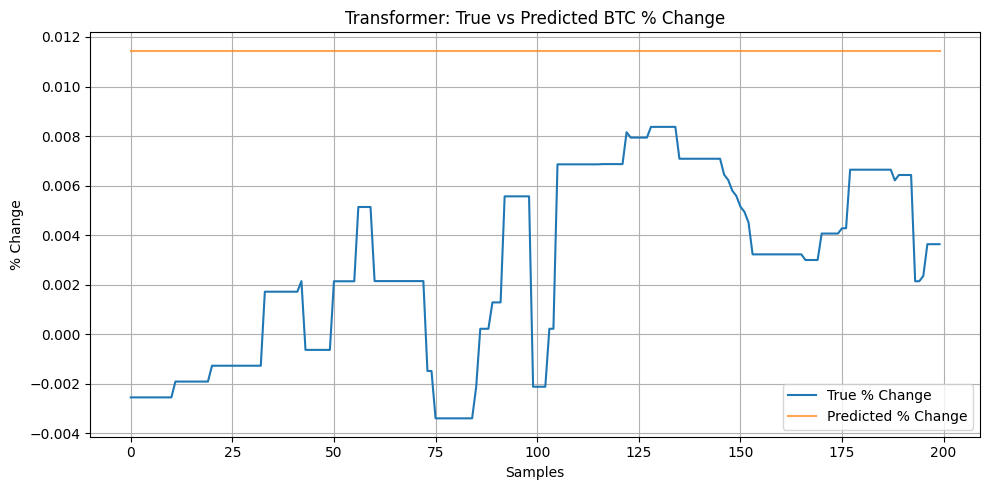

In [42]:
# eval
y_pred = transformer_model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Transformer MSE: {mse:.6f}")
print(f"Transformer MAE: {mae:.6f}")
print(f"Transformer R² Score: {r2:.6f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test[:200], label='True % Change')
plt.plot(y_pred[:200], label='Predicted % Change', alpha=0.7)
plt.title("Transformer: True vs Predicted BTC % Change")
plt.xlabel("Samples")
plt.ylabel("% Change")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()